In [1]:
# Import general python packages
import numpy as np
import pandas as pd

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline
# %matplotlib ipympl # currently slow, but may be a good option in the future
import matplotlib.pyplot as plt

# Set the maximum number of rows to display from pandas
pd.set_option('display.max_rows', 20)


In [2]:
# Ignore warnings
# import warnings
# from astropy.units import UnitsWarning
# warnings.simplefilter("ignore", category=UnitsWarning)

In [3]:
# Get an instance of the TAP service
service = get_tap_service()
assert service is not None
# assert service.baseurl == "https://data.lsst.cloud/api/tap"


In [4]:
# Define our reference position on the sky and cone radius in arcseconds
# to use in all following examples
coord = SkyCoord(ra=62.0*u.degree, dec=-37.0*u.degree, frame='icrs')
radius = 0.1 * u.deg

In [5]:
# Try looking at galaxies first
query = "SELECT obj.objectId, obj.ra, obj.dec, obj.mag_u, obj.mag_g, " \
        " obj.mag_r, obj.mag_i, obj.mag_z, obj.mag_y, obj.psFlux_u, " \
        "obj.psFlux_g, obj.psFlux_r, obj.psFlux_i, obj.psFlux_z, " \
        "obj.psFlux_y, obj.tract, obj.patch, " \
        "obj.extendedness, obj.good, obj.clean, " \
        "truth.mag_r as truth_mag_r, truth.match_objectId, "\
        "truth.flux_u, truth.flux_g, truth.flux_r, truth.flux_i, " \
        "truth.flux_z, truth.flux_y, truth.truth_type, truth.redshift, " \
        "truth.match_sep, truth.is_variable " \
        "FROM dp01_dc2_catalogs.object as obj " \
        "JOIN dp01_dc2_catalogs.truth_match as truth " \
        "ON truth.match_objectId = obj.objectId " \
        "WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', " \
        + str(coord.ra.value) + ", " + str(coord.dec.value) + ", " \
        + str(radius.value) + " )) = 1 " \
        "AND truth.match_objectid >= 0 " \
        "AND truth.is_good_match = 1" \
        "AND obj.clean = 1 AND obj.good = 1" \
        "AND obj.extendedness = 1"
print(query)

SELECT obj.objectId, obj.ra, obj.dec, obj.mag_u, obj.mag_g,  obj.mag_r, obj.mag_i, obj.mag_z, obj.mag_y, obj.psFlux_u, obj.psFlux_g, obj.psFlux_r, obj.psFlux_i, obj.psFlux_z, obj.psFlux_y, obj.tract, obj.patch, obj.extendedness, obj.good, obj.clean, truth.mag_r as truth_mag_r, truth.match_objectId, truth.flux_u, truth.flux_g, truth.flux_r, truth.flux_i, truth.flux_z, truth.flux_y, truth.truth_type, truth.redshift, truth.match_sep, truth.is_variable FROM dp01_dc2_catalogs.object as obj JOIN dp01_dc2_catalogs.truth_match as truth ON truth.match_objectId = obj.objectId WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', 62.0, -37.0, 0.1 )) = 1 AND truth.match_objectid >= 0 AND truth.is_good_match = 1AND obj.clean = 1 AND obj.good = 1AND obj.extendedness = 1


In [6]:
# For more detailed analysis of results, converting
# to a pandas dataframe is often very useful ("df" stands for "dataframe")
df = service.search(query).to_table().to_pandas()

# Use an assertion to make sure we got the correct number of results.
# assert len(df) == 15670
len(df.ra)

10957

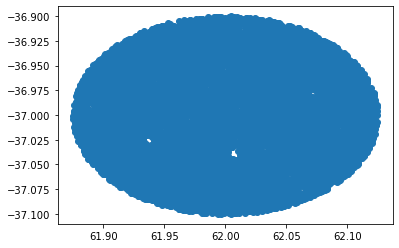

In [7]:
plt.scatter(df.ra, df.dec)

In [8]:
# Get rid of NaN values.
df2 = df.dropna
df2 = df.dropna(axis=0)

In [9]:
df.shape, df2.shape

((10957, 32), (8139, 32))

In [10]:
df2.columns

Index(['objectId', 'ra', 'dec', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z',
       'mag_y', 'psFlux_u', 'psFlux_g', 'psFlux_r', 'psFlux_i', 'psFlux_z',
       'psFlux_y', 'tract', 'patch', 'extendedness', 'good', 'clean',
       'truth_mag_r', 'match_objectId', 'flux_u', 'flux_g', 'flux_r', 'flux_i',
       'flux_z', 'flux_y', 'truth_type', 'redshift', 'match_sep',
       'is_variable'],
      dtype='object')

In [11]:
ugcolor = df2['mag_u'] - df2['mag_g']
grcolor = df2['mag_g'] - df2['mag_r']
ricolor = df2['mag_r'] - df2['mag_i']
izcolor = df2['mag_i'] - df2['mag_z']
zycolor = df2['mag_z'] - df2['mag_y']
df2['ugcolor'] = ugcolor
df2['grcolor'] = grcolor
df2['ricolor'] = ricolor
df2['izcolor'] = izcolor
df2['zycolor'] = zycolor

/tmp/ipykernel_14948/1239832705.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ugcolor'] = ugcolor
/tmp/ipykernel_14948/1239832705.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['grcolor'] = grcolor
/tmp/ipykernel_14948/1239832705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [12]:
df3 = df2.drop(['objectId', 'ra', 'dec', 'tract', 'patch', 'extendedness', 
                'good', 'clean'], axis=1)
df4 = df3.drop(['truth_type', 'match_sep', 'is_variable'], axis=1)
df4.columns

Index(['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'psFlux_u',
       'psFlux_g', 'psFlux_r', 'psFlux_i', 'psFlux_z', 'psFlux_y',
       'truth_mag_r', 'match_objectId', 'flux_u', 'flux_g', 'flux_r', 'flux_i',
       'flux_z', 'flux_y', 'redshift', 'ugcolor', 'grcolor', 'ricolor',
       'izcolor', 'zycolor'],
      dtype='object')

In [13]:
df5 = df4.drop(['mag_u', 'ugcolor', 'psFlux_r', 'psFlux_g', 'psFlux_u'], axis=1)

In [14]:
df5.columns

Index(['mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'psFlux_i', 'psFlux_z',
       'psFlux_y', 'truth_mag_r', 'match_objectId', 'flux_u', 'flux_g',
       'flux_r', 'flux_i', 'flux_z', 'flux_y', 'redshift', 'grcolor',
       'ricolor', 'izcolor', 'zycolor'],
      dtype='object')

In [15]:
df6 = df5.drop(['match_objectId', 'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y'], axis=1)

In [16]:
df2 = df6
del df6
del df5
del df4
del df3
del df

In [17]:
df3 = df2.drop(['psFlux_i', 'psFlux_z', 'psFlux_y'], axis=1)

In [18]:
df2 = df3
del df3
df2.columns

Index(['mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'truth_mag_r', 'redshift',
       'grcolor', 'ricolor', 'izcolor', 'zycolor'],
      dtype='object')

In [19]:
df2.corr()

,mag_g,mag_r,mag_i,mag_z,mag_y,truth_mag_r,redshift,grcolor,ricolor,izcolor,zycolor
mag_g,1.000000,0.858606,0.741416,0.643772,0.607660,0.845031,0.074799,0.281410,0.050082,-0.052311,0.046235
mag_r,0.858606,1.000000,0.913519,0.806532,0.765165,0.975035,0.340306,-0.250298,-0.064345,-0.088226,0.052631
mag_i,0.741416,0.913519,1.000000,0.828222,0.787102,0.915977,0.447129,-0.309742,-0.464734,0.000963,0.052192
mag_z,0.643772,0.806532,0.828222,1.000000,0.730970,0.812571,0.403912,-0.293887,-0.276213,-0.559602,0.362616
mag_y,0.607660,0.765165,0.787102,0.730970,1.000000,0.773588,0.384063,-0.284657,-0.265378,-0.140348,-0.370902
truth_mag_r,0.845031,0.975035,0.915977,0.812571,0.773588,1.000000,0.346020,-0.229207,-0.124715,-0.095367,0.049347
redshift,0.074799,0.340306,0.447129,0.403912,0.384063,0.346020,1.000000,-0.495744,-0.356143,-0.059509,0.025173
grcolor,0.281410,-0.250298,-0.309742,-0.293887,-0.284657,-0.229207,-0.495744,1.000000,0.215032,0.066354,-0.011199
ricolor,0.050082,-0.064345,-0.464734,-0.276213,-0.265378,-0.124715,-0.356143,0.215032,1.000000,-0.194399,-0.013474
izcolor,-0.052311,-0.088226,0.000963,-0.559602,-0.140348,-0.095367,-0.059509,0.066354,-0.194399,1.000000,-0.569880


Redshift appears to correlate best to, in order, grcolor(-0.496), mag_i(0.447), 
mag_z(0.404), mag_y(0.384), ricolor(-0.356), and mag_r(0.340).
All other values are < 0.15, so let's just look at those features.

Text(0, 0.5, 'redshift')

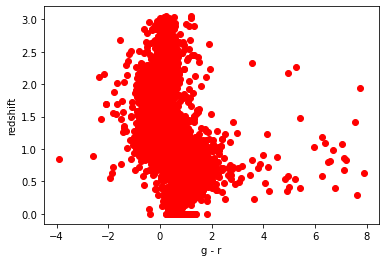

In [52]:
plt.scatter(df2.grcolor, df2.redshift, color = 'red')
plt.xlabel('g - r')
plt.ylabel('redshift')
# plt.gca().invert_xaxis()

In [21]:
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

In [22]:
# We don't know of the galaxies are ordered by redshift or come randomly. Thus we activate a pre-random-shuffling in the training dataset. 
# cv = ShuffleSplit(n_splits=5, test_size=.80, random_state=0)


In [23]:
target = df2.redshift
#features = np.array([df2.mag_r, ugcolor, grcolor, ricolor, izcolor, zycolor])
features = df2.grcolor
Ntot = len(target)
features.shape, target.shape

((8139,), (8139,))

In [24]:
features

0        0.051661
1        0.412158
2        0.644672
3        1.382438
4        1.412398
           ...   
10951    0.733324
10952    0.648440
10954    0.643265
10955    1.151521
10956    0.011809
Name: grcolor, Length: 8139, dtype: float64

In [25]:
target

0        0.962006
1        1.120860
2        0.631860
3        0.749955
4        0.292153
           ...   
10951    0.250911
10952    1.203240
10954    0.827515
10955    0.675414
10956    2.386490
Name: redshift, Length: 8139, dtype: float32

In [26]:
Ntrain = 2500
Ntest = Ntot-Ntrain

In [27]:
# Test fraction
test_sample_size_fraction=Ntest/Ntot
test_sample_size_fraction

0.6928369578572307

In [28]:
# adapt the train dataset size according required running time 
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)


In [29]:
# to fix this error, transpose features
# features = features.T
# features.shape

In [30]:
features = np.array(features)

In [31]:
features = features.reshape(-1, 1)

In [32]:
# Now try again
# adapt the train dataset size according required running time 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)


In [33]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(5639, 1) (5639,) (2500, 1) (2500,)


In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
features

array([[0.0516612],
       [0.4121577],
       [0.6446718],
       ...,
       [0.6432646],
       [1.1515211],
       [0.011809 ]])

In [36]:
y_model = model.predict(X_test)

In [37]:
model.score

<bound method RegressorMixin.score of LinearRegression()>

In [38]:
y_test

3523    0.904687
8582    0.524401
2534    2.184050
8931    1.733850
54      0.311188
          ...   
4472    1.675190
2668    1.035340
570     0.609842
71      1.010650
7967    0.803073
Name: redshift, Length: 5639, dtype: float32

In [39]:
y_model.reshape(-1, 1)

array([[1.00697415],
       [0.59270762],
       [1.16692357],
       ...,
       [0.58229804],
       [0.98479285],
       [0.33227545]])

In [40]:
# y_model = y_model[:, np.newaxis]

In [41]:
# y_test = y_test[:, np.newaxis]

In [42]:
y_test.shape, y_model.shape

((5639,), (5639,))

In [44]:
model.score(y_model.reshape(-1,1), y_test)

-0.6054056771200538

In [48]:
model.coef_

array([-0.48222215])

In [49]:
model.intercept_

1.304046287005006

In [56]:
redshift_predict = model.coef_ * df2['grcolor'] + model.intercept_

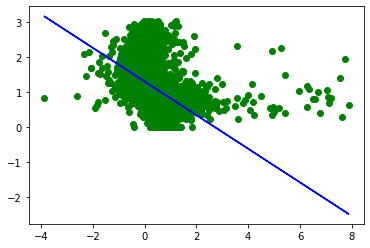

In [57]:
plt.scatter(df2['grcolor'], df2['redshift'], color='green')
plt.plot(df2['grcolor'], redshift_predict, color='blue')